In [1]:
import netCDF4 as nc
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from datetime import datetime as dt
import xarray as xr

In [2]:
def calc_rmse(column_a, column_b):
    return np.power(np.nanmean(((column_a - column_b) ** 2)), .5)

In [3]:
path_to_comparison_data = '/data/comparison_data/poker_flats_2010-2016_daily.csv'
cell_x_coord = 1
cell_y_coord = 0

In [4]:
comparison_data=pd.read_csv(path_to_comparison_data)
comparison_data = comparison_data.replace(-9999.0, np.nan)
comparison_data['date'] = pd.to_datetime(comparison_data['date'])

In [5]:
comparison_data_co2 = comparison_data.groupby(by=['year']).mean().reset_index()[['year','CO2_1_1_1', 'CO2_1_2_1']]
comparison_data_co2['co2_mean'] = np.nanmean([comparison_data_co2['CO2_1_1_1'], comparison_data_co2['CO2_1_2_1']], axis=0)
comparison_data_co2

,year,CO2_1_1_1,CO2_1_2_1,co2_mean
0,2010,383.452513,407.115744,395.284129
1,2011,352.732562,380.541468,366.637015
2,2012,367.192267,377.907803,372.550035
3,2013,402.680578,402.207673,402.444126
4,2014,407.178512,395.215016,401.196764
5,2015,400.655336,375.231221,387.943279
6,2016,402.344933,348.991181,375.668057


In [6]:
comparison_data['month'] = pd.DatetimeIndex(comparison_data['date']).month
comparison_data_pr = comparison_data.groupby(by=['year', 'month']).sum().reset_index()['P_RAIN']
comparison_data = comparison_data.groupby(by=['year', 'month']).mean().reset_index().drop(columns=['Unnamed: 0', 'DOY', 'X'])
comparison_data_pr[(comparison_data['month']<10)&(comparison_data['year']==2010)]=np.nan
comparison_data['P_RAIN'] = comparison_data_pr
comparison_data['m_y'] = pd.to_datetime(comparison_data['month'].astype(str) + '-'+ comparison_data['year'].astype(str), format='%m-%Y')
comparison_data.dtypes

year                     int64
month                    int64
USTAR_1_1_1            float64
USTAR_1_2_1            float64
WS_1_3_1               float64
                     ...      
TS_1_6_1               float64
D_SNOW_1_1_1           float64
D_SNOW_1_1_2           float64
D_SNOW_1_1_3           float64
m_y             datetime64[ns]
Length: 68, dtype: object

!ls /data/input-catalog/caribou-poker/

In [7]:
ds = nc.Dataset('/data/input-catalog/caribou-poker_merged/historic-climate.nc')
ds.variables

{'albers_conical_equal_area': <class 'netCDF4._netCDF4.Variable'>
 |S1 albers_conical_equal_area(string1)
     grid_mapping_name: albers_conical_equal_area
     false_easting: 0.0
     false_northing: 0.0
     latitude_of_projection_origin: 50.0
     longitude_of_central_meridian: -154.0
     standard_parallel: [55. 65.]
     longitude_of_prime_meridian: 0.0
     semi_major_axis: 6378137.0
     inverse_flattening: 298.2572221010002
     spatial_ref: PROJCS["NAD83 / Alaska Albers",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.2572221010002,AUTHORITY["EPSG","7019"]],TOWGS84[0,0,0,0,0,0,0],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["standard_parallel_1",55],PARAMETER["standard_parallel_2",65],PARAMETER["latitude_of_center",50],PARAMETER["longitude_of_center",-154],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHOR

In [8]:
tair = ds.variables['tair'][:,cell_y_coord,cell_x_coord]
nirr = ds.variables['nirr'][:,cell_y_coord,cell_x_coord]
vapor_press = ds.variables['vapor_press'][:,cell_y_coord,cell_x_coord]
precip = ds.variables['precip'][:,cell_y_coord,cell_x_coord]

starting_date = pd.to_datetime('1901-1-1 0:0:0')
timedeltas=[0 + i for i in range(0, np.shape(ds.variables['tair'])[0])]
#dates = [starting_date + pd.Timedelta(t, 'd') for t in timedeltas]
dates = [starting_date + pd.Timedelta(t, 'd') for t in ds.variables['time'][:]]
len(dates)


1464

In [9]:
ds = xr.open_dataset('/data/input-catalog/caribou-poker_merged/historic-climate.nc')
dates=ds.indexes['time'].to_datetimeindex()
dates

/tmp/ipykernel_689/496894541.py:2: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  dates=ds.indexes['time'].to_datetimeindex()


DatetimeIndex(['1901-01-01', '1901-02-01', '1901-03-01', '1901-04-01',
               '1901-05-01', '1901-06-01', '1901-07-01', '1901-08-01',
               '1901-09-01', '1901-10-01',
               ...
               '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01',
               '2022-07-01', '2022-08-01', '2022-09-01', '2022-10-01',
               '2022-11-01', '2022-12-01'],
              dtype='datetime64[ns]', length=1464, freq=None)

In [10]:
tem_output_df = pd.DataFrame({'date':dates, 'tair':tair, 'nirr': nirr, 'precip': precip, 'vapor_press': vapor_press})
tem_output_df['month'] = pd.DatetimeIndex(tem_output_df['date']).month
tem_output_df['year'] = pd.DatetimeIndex(tem_output_df['date']).year

In [11]:
#tem_output_df = tem_output_df.groupby(by=['year', 'month']).mean().reset_index()
#tem_output_df['m_y'] = pd.to_datetime(tem_output_df['month'].astype(str) + '-'+ tem_output_df['year'].astype(str), format='%m-%Y')
tem_output_df.dtypes

date           datetime64[ns]
tair                  float32
nirr                  float32
precip                float32
vapor_press           float32
month                   int64
year                    int64
dtype: object

In [12]:
temp_measurements = ['TA_1_1_1', 'TA_1_2_1', 'TA_1_3_1', 'TA_1_4_1', 'TA_1_5_1', 'TA_1_6_1', 'TA_1_7_1', 'TA_1_8_1', 'TA_1_9_1']

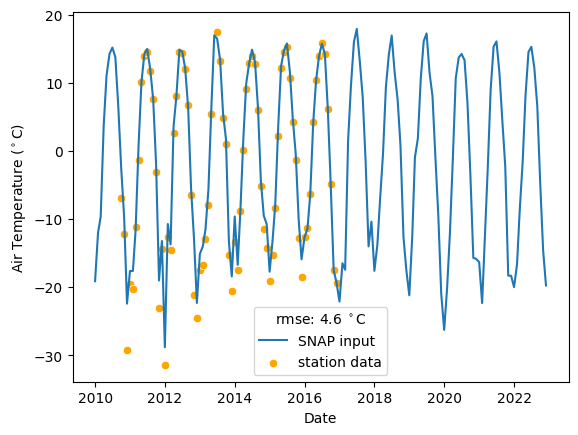

In [13]:
fig, ax = plt.subplots()
dt_comp = pd.to_datetime('2010-01-01')
sns.lineplot(data = tem_output_df[tem_output_df['date']>=dt_comp], x='date', y='tair', label = 'SNAP input')
sns.scatterplot(data = comparison_data[comparison_data['m_y']>=dt_comp], x = 'm_y', y= 'TA_1_1_1', label='station data', color='orange')
plt.ylabel('Air Temperature ($^\circ$C)')
plt.xlabel('Date')
rmse = np.around(calc_rmse(tem_output_df['tair'], comparison_data['TA_1_1_1']), decimals=1)
ax.legend(title='rmse: {} $^\circ$C'.format(rmse), title_fontsize=10)

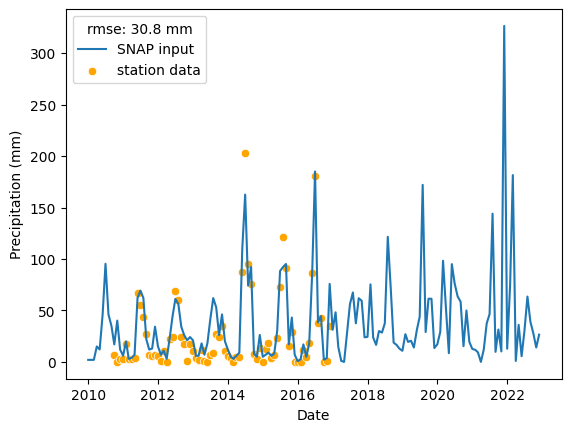

In [14]:
fig, ax = plt.subplots()
dt_comp = pd.to_datetime('2010-01-01')
sns.lineplot(data = tem_output_df[tem_output_df['date']>=dt_comp], x='date', y='precip', label = 'SNAP input')
sns.scatterplot(data = comparison_data[comparison_data['m_y']>=dt_comp], x = 'm_y', y= 'P_RAIN', label='station data', color='orange')
plt.ylabel('Precipitation (mm)')
plt.xlabel('Date')
rmse=np.around(calc_rmse(tem_output_df['precip'], comparison_data['P_RAIN']), decimals=1)
ax.legend(title='rmse: {} mm'.format(rmse), title_fontsize=10)

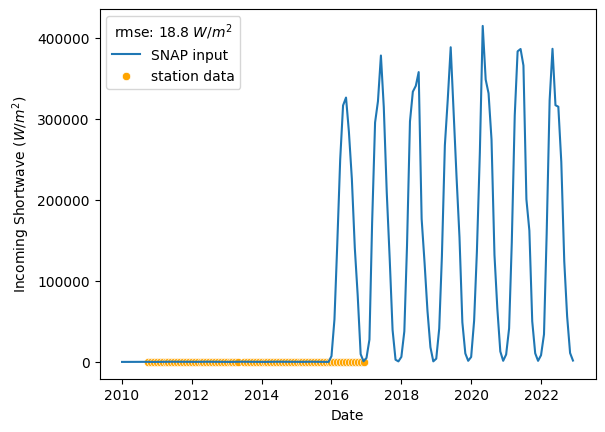

In [15]:
fig, ax = plt.subplots()
dt_comp = pd.to_datetime('2010-01-01')
sns.lineplot(data = tem_output_df[tem_output_df['date']>=dt_comp], x='date', y='nirr', label = 'SNAP input')
sns.scatterplot(data = comparison_data[comparison_data['m_y']>=dt_comp], x = 'm_y', y= 'SW_IN', label='station data', color='orange')
plt.ylabel('Incoming Shortwave ($W/m^2$)')
plt.xlabel('Date')
rmse=np.around(calc_rmse(tem_output_df['nirr'], comparison_data['SW_IN']), decimals=1)
ax.legend(title='rmse: {} $W/m^2$'.format(rmse), title_fontsize=10)

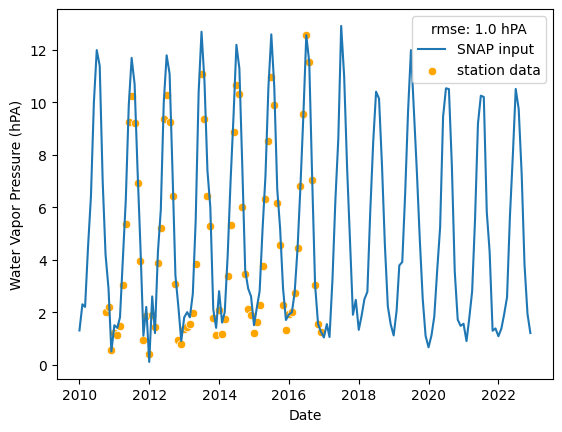

In [16]:
fig, ax = plt.subplots()
dt_comp = pd.to_datetime('2010-01-01')
t_kelvin = comparison_data['TA_1_1_1'] + 273.15
sat_vap_press = (611*np.exp((17.27*comparison_data['TA_1_1_1'])/t_kelvin))/100
vap_press = ((comparison_data['RH_1_1_1']/100) * sat_vap_press)
sns.lineplot(data = tem_output_df[tem_output_df['date']>=dt_comp], x='date', y='vapor_press', label = 'SNAP input')
sns.scatterplot(data = comparison_data[comparison_data['m_y']>=dt_comp], x = 'm_y', y= vap_press, label='station data', color='orange')
plt.ylabel('Water Vapor Pressure (hPA)')
plt.xlabel('Date')
rmse=np.around(calc_rmse(tem_output_df['vapor_press'], vap_press), decimals=1)
ax.legend(title='rmse: {} hPA'.format(rmse), title_fontsize=10)

In [17]:
tem_co2 = nc.Dataset('/data/input-catalog/caribou-poker/co2.nc')

In [18]:
tem_co2

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    data_source: https://www.esrl.noaa.gov/gmd/ccgg/trends/data.html
    source: /home/UA/tcarman2/dvm-dos-tem/./scripts/create_region_input.py::make_co2_file
    dimensions(sizes): year(115)
    variables(dimensions): int64 year(year), float32 co2(year)
    groups: 

In [19]:
tem_co2.variables['year'][:]

masked_array(data=[1901, 1902, 1903, 1904, 1905, 1906, 1907, 1908, 1909,
                   1910, 1911, 1912, 1913, 1914, 1915, 1916, 1917, 1918,
                   1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927,
                   1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936,
                   1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945,
                   1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954,
                   1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963,
                   1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
                   1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981,
                   1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990,
                   1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999,
                   2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008,
                   2009, 2010, 2011, 2012, 2013, 2014, 2015],
             mask=False,
       fill_value=999999)

In [20]:
tem_co2_df = pd.DataFrame({'year': tem_co2.variables['year'][:], 'co2': tem_co2.variables['co2'][:]})
tem_co2_df

,year,co2
0,1901,296.311005
1,1902,296.661011
2,1903,297.040009
3,1904,297.441010
4,1905,297.859985
...,...,...
110,2011,391.649994
111,2012,393.850006
112,2013,396.519989
113,2014,398.649994


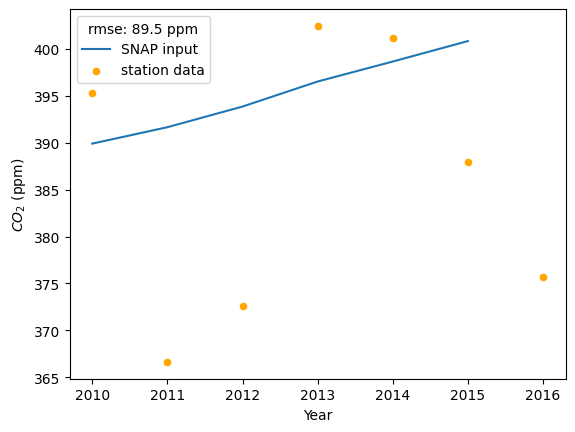

In [21]:
fig, ax = plt.subplots()
sns.lineplot(data = tem_co2_df[tem_co2_df['year']>=2010], x='year', y='co2', label = 'SNAP input')
sns.scatterplot(data = comparison_data_co2[comparison_data_co2['year']>=2010], x = 'year', y= 'co2_mean', label='station data', color='orange')
plt.ylabel('$CO_{2}$ (ppm)')
plt.xlabel('Year')
rmse=np.around(calc_rmse(tem_co2_df['co2'], comparison_data_co2['co2_mean']), decimals=1)
ax.legend(title='rmse: {} ppm'.format(rmse), title_fontsize=10)